In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.bool = np.bool_
np.int = np.int_
np.object = np.object_
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

In [ ]:
normal_train_data = tf.convert_to_tensor(np.load('normal_train_data.npy'))
normal_test_data = tf.convert_to_tensor(np.load('normal_test_data.npy'))
anomalous_train_data = tf.convert_to_tensor(np.load('anomalous_train_data.npy'))
anomalous_test_data = tf.convert_to_tensor(np.load('anomalous_test_data.npy'))
train_data = tf.convert_to_tensor(np.load('train_data.npy'))
test_data = tf.convert_to_tensor(np.load('test_data.npy'))
train_labels = tf.convert_to_tensor(np.load('train_labels.npy'))
test_labels = tf.convert_to_tensor(np.load('test_labels.npy'))

In [6]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([4, 8, 16, 32, 64]))


class BinaryClassfier(Model):
  def __init__(self, hp):
    super(BinaryClassfier, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Dense(hp, activation="relu"), layers.Dense(1, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    return encoded

  
def model_builder(hp):
  
  hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
  model = BinaryClassfier(hp_units)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ["accuracy"])

  return model

In [7]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("accuracy", "max"),
                     max_epochs=50,
                     factor=2,
                     directory='my_dir_binary',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Tuner from my_dir_binary\intro_to_kt\tuner0.json


In [8]:
tuner.search(train_data, train_labels,
          validation_data=(test_data, test_labels),
          shuffle=True)

# Get the optimal hyperparameters




Search: Running Trial #130

Value             |Best Value So Far |Hyperparameter
64                |64                |units
7                 |50                |tuner/epochs
0                 |25                |tuner/initial_epoch
3                 |5                 |tuner/bracket
0                 |5                 |tuner/round

Epoch 1/7
125/125 [==============================] - 3s 5ms/step - loss: 0.5755 - accuracy: 0.7449 - val_loss: 0.4404 - val_accuracy: 0.8730
Epoch 2/7
125/125 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.9457 - val_loss: 0.2360 - val_accuracy: 0.9600
Epoch 3/7
125/125 [==============================] - 0s 4ms/step - loss: 0.1977 - accuracy: 0.9512 - val_loss: 0.1612 - val_accuracy: 0.9610
Epoch 4/7
125/125 [==============================] - 1s 5ms/step - loss: 0.1477 - accuracy: 0.9535 - val_loss: 0.1225 - val_accuracy: 0.9700
Epoch 5/7
125/125 [==============================] - 1s 5ms/step - loss: 0.1229 - accuracy: 0.9612

KeyboardInterrupt: 

In [9]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 64,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 25,
 'tuner/bracket': 5,
 'tuner/round': 5,
 'tuner/trial_id': '0072'}

In [30]:
autoencoder = tuner.hypermodel.build(best_hps)
history = autoencoder.fit(train_data, train_labels, epochs=50, initial_epoch=25, 
          validation_data=(test_data, test_labels))

Epoch 26/50
125/125 [==============================] - 1s 6ms/step - loss: 0.5583 - accuracy: 0.7611 - val_loss: 0.4236 - val_accuracy: 0.9650
Epoch 27/50
125/125 [==============================] - 1s 5ms/step - loss: 0.3148 - accuracy: 0.9470 - val_loss: 0.2184 - val_accuracy: 0.9640
Epoch 28/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1844 - accuracy: 0.9540 - val_loss: 0.1463 - val_accuracy: 0.9680
Epoch 29/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1383 - accuracy: 0.9562 - val_loss: 0.1138 - val_accuracy: 0.9720
Epoch 30/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1166 - accuracy: 0.9602 - val_loss: 0.0946 - val_accuracy: 0.9740
Epoch 31/50
125/125 [==============================] - 1s 5ms/step - loss: 0.1020 - accuracy: 0.9670 - val_loss: 0.0836 - val_accuracy: 0.9770
Epoch 32/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0879 - accuracy: 0.9695 - val_loss: 0.0733 - val_accuracy: 0.9740

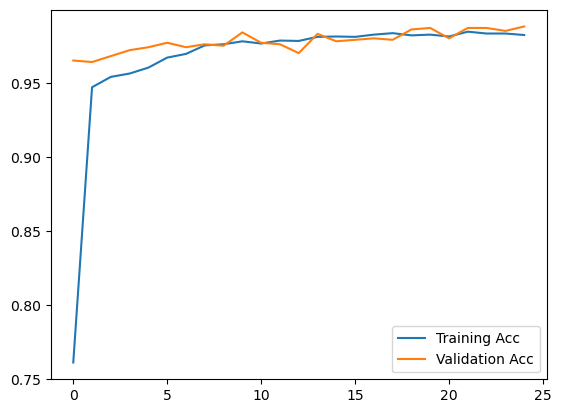

In [31]:
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend()

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  return [not i  for i in tf.math.less(reconstructions, threshold)]

def print_stats(predictions, labels):
    # Calculate overall accuracy
    accuracy = accuracy_score(labels, predictions)
    print("Overall Accuracy = {:.2f}".format(accuracy))
    # Print the classification report for a detailed view
    print("\nClassification Report:")
    print(classification_report(labels, predictions))

Overall Accuracy = 0.99

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       408
        True       0.99      0.99      0.99       592

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



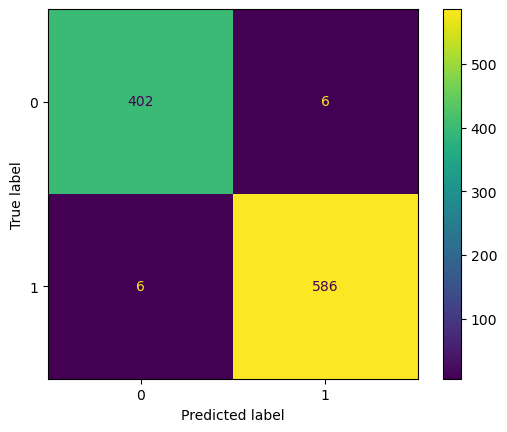

In [35]:
preds = predict(autoencoder, test_data, 0.5)

print_stats(preds, test_labels)
ConfusionMatrixDisplay(confusion_matrix(test_labels, preds)).plot()